In [1]:
# Define dataset
import torch
import h5py
from datetime import datetime, timedelta
import torch.nn.functional as F
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print('datetime',datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
class radarDataset_resized(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 4, pred_number = 12, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = [] # Output is a list of images rather than a single image
        time_list = time_list_obs + time_list_pre
        #print('time list',time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            output.append(image)
        output = torch.tensor((np.array(output)), dtype = torch.float32)
        # Reshape tensor to include a batch dimension (B, C, H, W)
        output = output.unsqueeze(0)
        # Resize tensor using F.interpolate
        output = F.interpolate(output, size=(128, 128), mode='bilinear', align_corners=False)
        # Remove batch dimension
        output = torch.squeeze(output, 0) # output : [C, H, W]
        return output


In [2]:
# develop dataset
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 
batch_size=1

df_train = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset_resized(root_dir, event_times, transform = None)  

df_train_s = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset_resized(root_dir, event_times, transform = None)  

df_test = pd.read_csv('/users/ankushroy/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset_resized(root_dir, event_times, transform = None)

df_vali = pd.read_csv('/users/ankushroy/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset_resized(root_dir, event_times, transform = None)

df_train_aa = pd.read_csv('/users/ankushroy/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset_resized(root_dir, event_times, transform = None)  

df_train_dw = pd.read_csv('/users/ankushroy/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset_resized(root_dir, event_times, transform = None)    

df_train_re = pd.read_csv('/users/ankushroy/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset_resized(root_dir, event_times, transform = None)   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(train_aadedwre), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size, shuffle=False, num_workers=8),
          }
print(dataset_test[0].shape)

30632 3493 3560
torch.Size([16, 128, 128])


In [6]:
images_list = [img.to('cpu').detach().numpy() for img in dataset_test]  # Assuming the images are PyTorch tensors

# Stack the list of arrays into one large numpy array
images_array = np.stack(images_list)

# Save the numpy array
np.save('/users/ankushroy/iris_1/images_array.npy', images_array)


In [7]:
print(images_array.shape)

(3493, 9, 128, 128)


Visualizing the images

In [ ]:
from einops import rearrange
from pysteps.visualization import plot_precip_field
import matplotlib.pyplot as plt
device = 'cuda:0'
for i, images in enumerate(loaders['train']):
    if i>=5:break
    image = images[0]
    print(images.shape)
    print(image.shape)
    image = image.unsqueeze(1)
    image = image[3:4,:, :, :] # [9,128,128] --> [9,1,128,128]
    input_image= image.to(device)
    a_r_display = input_image[0,0,:,:].to('cpu').detach().numpy()*40
    plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plot_precip_field(a_r_display, title="Input")
    plt.tight_layout()
    plt.show()

According to what Cristian taught

In [13]:
from einops import rearrange
from pysteps.visualization import plot_precip_field
import matplotlib.pyplot as plt
device = 'cuda:0'
for i, images in enumerate(loaders['train']):
    if i>=1:break
    images=images.unsqueeze(0)
    print(images.shape)
    images = rearrange(images, 'c b t h w  -> (b t) c h w')
    input_image = images[i,1,:,:].to(device)
    a_r_display = input_image.to('cpu').detach().numpy()*40
    plt.figure(figsize=(16, 4))
    plot_precip_field(a_r_display, title="Input")
    plt.tight_layout()
    plt.show()    

torch.Size([1, 1, 16, 128, 128])


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [45]:
np.set_printoptions(threshold=np.inf)
for i, images in enumerate(loaders['train']):
    if i==0:
        print(images[1,5,:,:].numpy()*40)  # (B, S, H, W)

    i = i+1
    if i>0:
        break
print(np.max(images[0,5,:,:].numpy()*40))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.06       0.32999998 0.32999998
  0.35999998 0.45000002 0.26999998 0.29999998 0.42       0.84000003
  1.26       1.0500001  0.87000006 1.23       1.17       0.90000004
  0.63       0.65999997 0.78000003 0.75       0.96000004 0.93
  0.78       0.63       0.39000002 0.35999998 0.21       0.26999998
  0.45000002 0.65999997 0.84000003 0.84000003 0.84000003 0.90000004
  0.87       0.75       0.54       0.35999998 0.29999998 0.35999998
  0.35999998 0.35999998 0.35999998 0.42       0.48000002 0.48000002
  0.48000002 0.48000002 0.6        0.6    

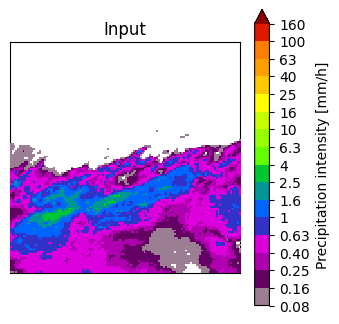

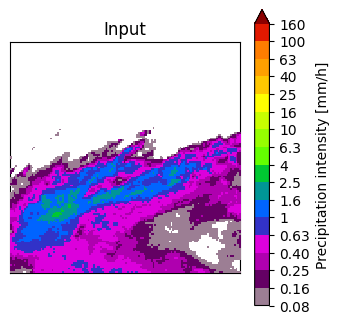

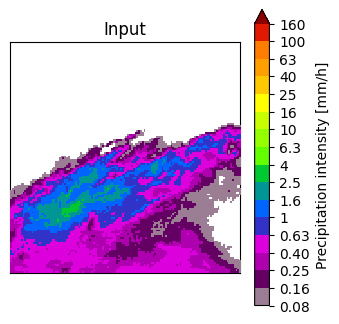

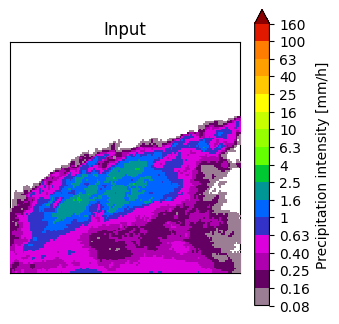

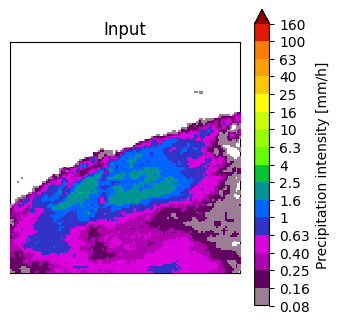

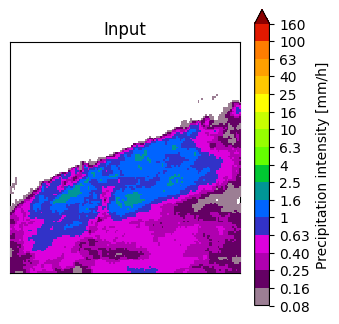

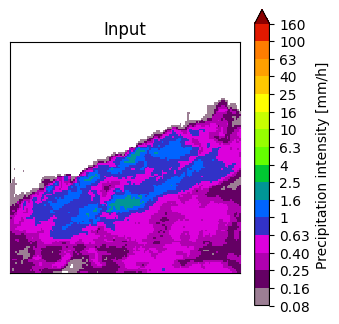

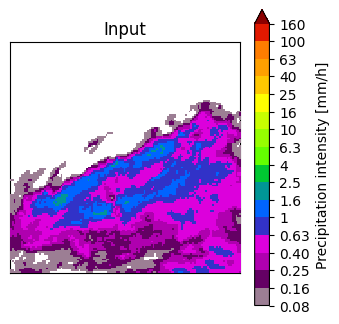

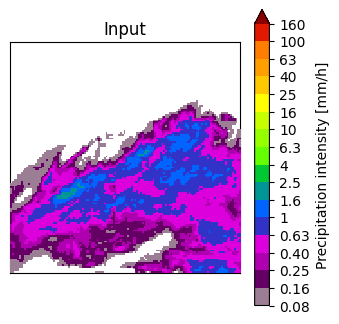

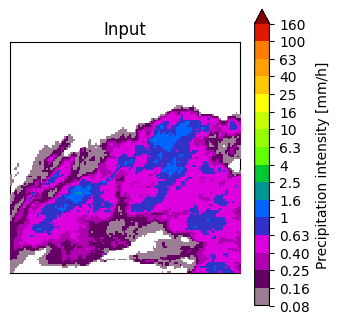

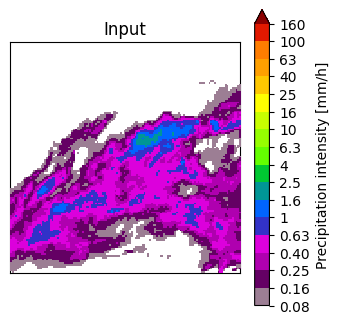

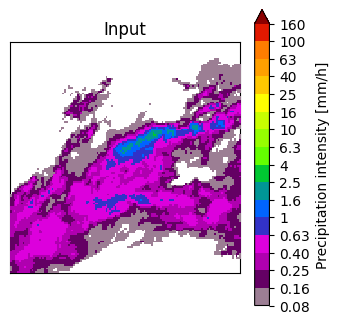

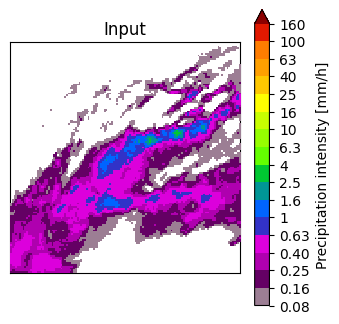

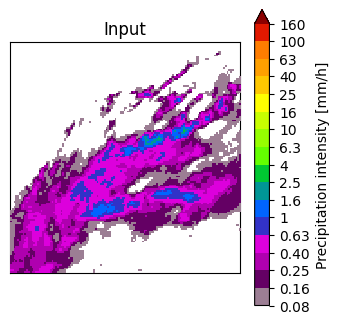

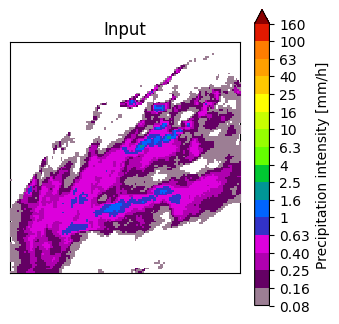

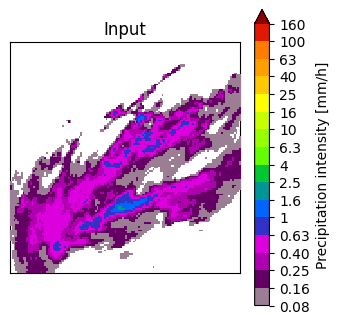

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

In [48]:
from pysteps.visualization import plot_precip_field
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
all_data_test = np.load('/space/ankushroy/Data/all_data_test.npy')
image_seq = all_data_test[3400]
for i in range (image_seq.shape[0]):
    image = image_seq[i,:,:]*40 #    Important post-processing step
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plot_precip_field(image, title="Input")
    plt.tight_layout()
    plt.show()

print(all_data_test[3400,0,:,:]*40)    

In [ ]:
import numpy as np
from pysteps.visualization import plot_precip_field
import matplotlib.pyplot as plt
all_data_test = np.load('/space/ankushroy/Data/all_data_test.npy')
print(all_data_test.shape)
image_seq = all_data_test[1843]

width_per_image = 20  # Adjust this value as needed
height_per_image = 20   # Adjust this value as needed

plt.figure(figsize=(width_per_image * image_seq.shape[0], height_per_image))

for i in range (image_seq.shape[0]):
    image = image_seq[i,:,:]*40 #    Important post-processing step
    plt.subplot(1, image_seq.shape[0], i + 1)
    plot_precip_field(image, title=f"Input {i + 1}")
    
plt.tight_layout()
plt.show()
